# Image Classification - Softmax Regression

## Introduction

In this exercise you will learn how to classify images of handwritten digits. For classification you will implement the logistic regression, or better said, as we have more than two classes, softmax regression. Further you will learn about _stochastic gradient descent_ (opposed to _gradient descent_) and for evaluation of your model, the accuracy and f1-score.

## Requirements

### Knowledge

Required knowledge:

- Machine learning models linear models
- Gradient descent.
- Softmax 
- pytorch 

##### Literature:
- Lecture Notes of CS231n: [Linear classification: Support Vector Machine, Softmax](https://cs231n.github.io/linear-classify/) .
- Eli Bendersky [blog post](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/) about
Softmax and its derivative.

- Pytorch tutorials
 - [deep learning with pytorch: s 60 minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
 - [learning pytorch with examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)
 - [What is torch nn really?](https://pytorch.org/tutorials/beginner/nn_tutorial.html)

### Python Modules

With the deep.TEACHING convention, all python modules needed to run the notebook are loaded centrally at the beginning. 

In [1]:
# All necessary imports at the beginning
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
import gzip
import urllib.request
import pandas as pd
import sklearn

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

## Load, Explore and Prepare Dataset

The MNIST dataset is a classic Machine Learning dataset you can get it and more information about it from the website of [Yann Lecun](http://yann.lecun.com/exdb/mnist/). MNIST contains handwrittin digits and is split into a trainings set of 60000 examples and a test set of 10000 examples. You can use the module ```sklearn``` to load the MNIST dataset in a convenient way. 
easy load, mldata.org, orginal mnist, mnist link and description

**Note:**

If the cells below throws an error, the problem might be a broken download link. In that case, download the dataset from another source, e.g. from https://www.kaggle.com/avnishnish/mnist-original, and unzip it and place it under `BASE_DATA_DIR`.

In [3]:
BASE_DATA_DIR = os.path.expanduser('~/deep.TEACHING/data')

class Mnist:
    """Downloads, loads into numpy array and reshapes the common machine learning dataset: MNIST

    The MNIST dataset contains handwritten digits, available from http://yann.lecun.com/exdb/mnist/,
    has a training set of 60,000 examples, and a test set of 10,000 examples. With the class you can
    download the dataset and prepare them for usage, e.g., flatten the images or hot-encode the labels.
    """

    def __init__(self, data_dir=None, auto_download=True, verbose=True):
        """Downloads and moves MNIST dataset in a given folder.

        MNIST will be downloaded from http://yann.lecun.com/exdb/mnist/ and moved
        into the folder 'data_dir', if a path is given by the user, else files
        will be moved into a folder specified by the deep-teaching-commons
        config file.

        Args:
            data_dir: A string representing a path where you want to store MNIST.
            auto_download: A boolean, if True and the given 'data_dir' does not exists, MNIST will be download.
            verbose: A boolean indicating more user feedback or not.
        """
        self.data_dir = data_dir
        self.verbose = verbose

        if self.data_dir is None:
            self.data_dir = os.path.join(BASE_DATA_DIR, 'MNIST')

        self.data_url = 'http://yann.lecun.com/exdb/mnist/'
        self.files = ['train-images-idx3-ubyte.gz','train-labels-idx1-ubyte.gz','t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']

        if auto_download:
            if self.verbose:
                print('auto download is active, attempting download')
            self.download()

    def download(self):
        """Downloads MNIST dataset.

        Creates a directory, downloads MNIST and moves the data into the
        directory. MNIST source and target directory are defined by
        class initialization (__init__).

        TODO:
            Maybe redesign so it can be used as standalone method.
        """
        if os.path.exists(self.data_dir):
            if self.verbose:
                print('mnist data directory already exists, download aborted')
        else:
            if self.verbose:
                print('data directory does not exist, starting download...')
            # Create directories
            os.makedirs(self.data_dir)
            # Download each file and move it to given self.data_dir
            for file in self.files:
                urllib.request.urlretrieve(self.data_url + file, file)
                shutil.move(file, os.path.join(self.data_dir, file))
                if self.verbose:
                        print(file,'successfully downloaded')
            if self.verbose:
                print('... mnist data completely downloaded, enjoy.')

    def get_all_data(self, one_hot_enc=None, flatten=True, normalized=None):
        """Loads MNIST dataset into four numpy arrays.

        Default setup will return training and test images in a flat resprensentaion,
        meaning each image is row of 28*28 (784) pixel values. Labels are encoded as
        digit between 0 and 9. You can change both representation using the arguments,
        e.g., to preserve the image dimensions.

        Args:
            one_hot_enc (boolean): Indicates if labels returned in standard (0-9) or one-hot-encoded form
            flatten (boolean): Images will be returned as vector (flatten) or as matrix
            normalized (boolean): Indicates if pixels (0-253) will be normalized

        Returns:
            train_data (ndarray): A matrix containing training images
            train_labels (ndarray): A vector containing training labels
            test_data (ndarray): A matrix containing test images
            test_labels (ndarray): A vector containing test labels
        """
        train_images = self.get_images(os.path.join(self.data_dir,self.files[0]))
        train_labels = self.get_labels(os.path.join(self.data_dir,self.files[1]))
        test_images = self.get_images(os.path.join(self.data_dir,self.files[2]))
        test_labels = self.get_labels(os.path.join(self.data_dir,self.files[3]))

        if one_hot_enc:
            train_labels, test_labels = [self.to_one_hot_enc(labels) for labels in (train_labels, test_labels)]

        if flatten is False:
            train_images, test_images = [images.reshape(-1,28,28) for images in (train_images, test_images)]

        if normalized:
            train_images, test_images = [images/np.float32(256) for images in (train_images, test_images)]

        return train_images.copy(), train_labels.copy(), test_images.copy(), test_labels.copy()

    def get_images(self, file_path):
        """Unzips, reads and reshapes image files.

        Args:
            file_path (string): mnist image data file

        Returns:
            ndarray: A matrix containing flatten images
        """
        with gzip.open(file_path, 'rb') as file:
            images = np.frombuffer(file.read(), np.uint8, offset=16)
        return images.reshape(-1, 28 * 28)

    def get_labels(self, file_path):
        """Unzips and read label file.

        Args:
            file_path (string): mnist label data file

        Returns:
            ndarray: A vector containing labels
        """
        with gzip.open(file_path, 'rb') as file:
            labels = np.frombuffer(file.read(), np.uint8, offset=8)
        return labels


    def to_one_hot_enc(self, labels):
        """Converts standard MNIST label representation into an one-hot-encoding.

        Converts labels into a one-hot-encoding representation. It is done by
        manipulating a one diagonal matrix with fancy indexing.

        Args:
            labels (ndarray): Array of mnist labels

        Returns:
            ndarray: A matrix containing a one-hot-encoded label each row

        Example:
            [2,9,0] --> [[0,0,1,0,0,0,0,0,0,0]
                         [0,0,0,0,0,0,0,0,0,1]
                         [1,0,0,0,0,0,0,0,0,0]]
        """
        return np.eye(10)[labels]


In [4]:
mnist = Mnist()
X_train_all, y_train_all, X_test, y_test = mnist.get_all_data(one_hot_enc=True, flatten=True)

auto download is active, attempting download
mnist data directory already exists, download aborted


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.16666, 
                                                  shuffle=True, random_state=66)#42)

Note the shape and the range of the features and labels. Preprocess the data if necessary?

In [6]:
X_train.min(), X_train.max()

(0, 255)

In [7]:
X_train.shape, y_train.shape

((50000, 784), (50000, 10))

To get a visualization of MNIST we will plot a digit. Each line represents an image in flatten form (all pixel in a row). We have change the shape from a vector back to a matrix of the original shape to plot the image. In the case of MNIST this means a conversion of 784 pixel into 28x28 pixel. In addition we will check the label of that digit to verify it correspond to the image.

In [10]:
len(y_train)

50000

label: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


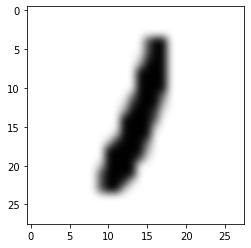

In [11]:
def plot_mnist_digit(digit):
    image = digit.reshape(28, 28)
    plt.imshow(image, cmap='binary', interpolation='bicubic')

#choose a random number, plot it and check label 
random_number = np.random.randint(1,len(X_train)-1)
print('label:', y_train[random_number]) 
plot_mnist_digit(X_train[random_number])

## Exercises

### Plot Digits

After a glimpse into MNIST let us explore it a bit further. 

**Task:**

Write a function ``` plot_mnist_digits(data, examples_each_row)``` that plots configurable number of examples for each class, like:
![internet connection needed](https://gitlab.com/deep.TEACHING/educational-materials/raw/master/media/voigt/images/MNIST_matrix.png)


In [12]:
def plot_mnist_digits(X, y, examples_each_row):
    ############################################
    #TODO: Write a function that plots as many #    
    #      examples of each class as defined   #
    #      by 'examples_each_row'              #
    ############################################
    
    pass 
    #raise NotImplementedError()
    
    
    ############################################
    #             END OF YOUR CODE             #
    ############################################
    
plot_mnist_digits(X_train, y_train, examples_each_row=10)

Encapsulate the training and the test set in a pytorch `DataLoader` with batchsize 32.
Pytorch’s `DataLoader` is responsible for managing batches. 

In [14]:
train_data_loader = None # your task

In [18]:
# let's gat a mini batch
X_mini_batch, y_mini_batch = train_data_loader.__iter__().next()
X_mini_batch.shape, X_mini_batch.dtype

(torch.Size([256, 784]), torch.float64)

### Define a Linear Classifier Using Softmax

#### Softmax Regression Model

First a linear transformation of the data is performed to calculate the 
_logits_ or _score_ values (before *softmax*). Note that $\vec f$ is a vector.

$$\vec f(\vec x) = \vec x^T \cdot \vec W + \vec b $$
with 
- $\vec x$ is an image as vector, e.g. $\vec x^{(m)}$ is the $m$-th training image. 
- $K$ is the number of classes (10 for MNIST) and $k$ is the class index.
- $M$ is the number of training examples.
- $N$ is the number of features (image pixels).
- $W$: Weight matrix with $N$ rows and $K$ columns (parameter of the model). 
- $\vec b$: Bias-vector (parameter of the model)

Each element $f_k$ of $\vec f(\vec x)$ is the logit value of the $k$-th class. 
So, $f_{y^{(m)}}(\vec x^{(m)})$ is the logit value
   of the label class $y^{(m)}$ for image $\vec x^{(m)}$.

From $\vec f$ the prediction probabilities are computed by softmax:

$$\vec h(\vec x) = \text{softmax} (\vec f ( \vec x  ))$$

The elements of $\vec h$ are $h_k(\vec x)$.  $h_k(\vec x)$ is the predicted probability 
that $\vec x$ belongs to class $k$:

 $$h_k(\vec x) = p( \text{class} = k \mid \vec x; \Theta)$$
 
So,
$$
h_{y^{(m)}}(\vec x) = \frac{ \exp\left({f_{y^{(m)}}(\vec x^{(m)}; \Theta)}\right)}{\sum_{k=1}^{K}\exp\left({f_k(\vec x^{(m)}; \Theta)}\right)} 
$$
 is the predicted probability for the label class of image $m$:
 



#### Tasks

Answer the following questions about _softmax_ :


1. What is the _range_ (possible values) of the softmax function?
2. What is the sum of all softmax outputs?
2. Assume the logit of output $k$ is increased a little bit (the other logits stay constant).
How changes the softmax of output $k$? How change the other softmax outputs?




#### Cost function

We will train a model to classify the MNIST dataset with the following equation for the cost function (loss):

$$ J(W, \vec b) = \frac{1}{M} \sum_{m=1}^{M} - \log\; \frac{ \exp\left({f_{y^{(m)}}(\vec x^{(m)}; W, \vec b)}\right)}{\sum_{k=1}^{K}\exp\left({f_k(\vec x^{(m)}; W, \vec b)}\right)}  + \lambda \sum_{k=1}^{K}\sum_{n=1}^{N} w_{nk}^2 \label{eq:cost_function} \tag{1} $$

with 
- $J(W, \vec b)$: Cost function (also called loss $L$)

Here, the sum is over all training examples (full batch). 

In stochastic gradient descent the cost (and the gradient) is computed in each iteration just for a mini batch.
A mini batch is a small fraction of the training data. 


#### Tasks

Answer the following questions about the cost function:

1. What is the meaning of the first term of equation $\eqref{eq:cost_function}$? 
$$\frac{1}{M} \sum_{m=1}^{M} - \log\; \frac{ \exp\left({f_{y^{(m)}}(\vec x^{(m)}; W, \vec b)}\right)}{\sum_{k=1}^{K}\exp\left({f_k(\vec x^{(m)}; W, \vec b)}\right)} $$ 


2. What is the meaning of the second term of equation $\eqref{eq:cost_function}$?
$$
\lambda \sum_{k=1}^{K}\sum_{n=1}^{N} w_{nk}^2
$$
What is the purpose of this term?

3. How many parameters has the model? 

4. Explain why 
$$ 
- \log\; \frac{ \exp\left({f_{y^{(m)}}(\vec x^{(m)}; W, \vec b)}\right)}{\sum_{k=1}^{K}\exp\left({f_k(\vec x^{(m)}; W, \vec b)}\right)} 
$$
is equivalent to
$$
- {f_{y^{(m)}}(\vec x^{(m)}; W, \vec b)} + \log \sum_{k=1}^{K}\exp\left({f_k(\vec x^{(m)}; W, \vec b)}\right)
$$

5. What is the difference between full batch and mini-batch training? What is a mini batch? What are the advantages of mini-batch training?

#### Side Note: Probabilistic interpretation

Note that $$h_k(\vec x; W, \vec b) = p( k \mid \vec x; W, \vec b)$$ 

with 
- $p( k \mid \vec x; W, \vec b)$ predicted probability that image $\vec x$ belongs to class $k$.

So, 
$$
\begin{align}
J(W, \vec b) &= \frac{1}{M} \sum_{m=1}^{M} - \log\; \frac{ \exp\left({f_{y^{(m)}}(\vec x^{(m)}; W, \vec b)}\right)}{\sum_{k=1}^{K}\exp\left({f_k(\vec x^{(m)}; W, \vec b)}\right)}  + \lambda \sum_{k=1}^{K}\sum_{n=1}^{N} w_{nk}^2  \\
&= \frac{1}{M} \sum_{m=1}^{M} L^{(m)}  + \frac{\lambda}{2} \sum_{k=1}^{K}\sum_{n=1}^{N} w_{nk}^2
\end{align}
$$


$$ L^{(m)} (W, \vec b) = 
- \log\; \frac{ \exp\left({f_{y^{(m)}}(\vec x^{(m)}; W, \vec b)}\right)}{\sum_{k=1}^{K}\exp\left({f_k(\vec x^{(m)}; W, \vec b)}\right)}=- \log h_{y^{(m)}}(\vec x; W, \vec b) = - \log p( y^{(m)} \mid \vec x; W, \vec b)
$$

- $L^{(m)}$ seen as a function of $W, \vec b$ is the (point-wise) negative log-_likelihood_.

**Task:**

Let us start with the logits / class scores:

$$F(X; W, \vec b) = X \cdot W +  \vec b $$

It is possible to calculate all score values of many examples at once
with one matrix multiplication and an addition with broadcasted bias vector. 
So, we can compute all logits of all images of a mini batch $X^{(i)}$ 
instead of one one digit image $\vec x^{(m)}$. 

#### Task

We want to use the build-in loss of pytorch for training. 
Explain the difference between `torch.nn.CrossEntropyLoss` and `torch.nn.NLLLoss`?
How does the appropriate loss depends on the model definition?

#### Task:

How do we can implement l2-regularization easily with pytorch? 

#### Task

Implement the training loop:

Plot such graphs for a training loop.
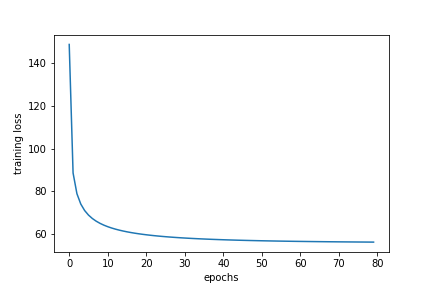
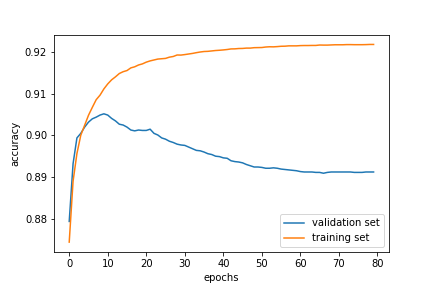

In [24]:
lr = 10. # adapt learning rate
weight_decay=1. # adapt weight decay
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

nb_epochs = -1 # adapt number of epochs

for epoch in range(nb_epochs):
    for X_mini_batch, y_mini_batch in train_data_loader:

        # Step 1. Run our forward pass.
        

        # Step 2. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        

        # Step 3. Clear gradients
        
        
       pass

#### Optimize the hyperparameters 

Optimize the hyperparameters with the validation set (not the test set!).
You should get an accuracy at least 0.89 on the validation set. 

Which best validation accuracy can you get?



#### Final result

Use the test set to evaluate the quality of your model (accuracy).

### Visualize the learnt parameter


One of the benefits of a simple linear model like softmax regression is 
that we can visualize the parameters $\theta$ for each of the classes, 
and see what input it prefers for a strong output.


In [36]:
# copy the weights into W with shape [nb_classes, nb_features] 
W = None

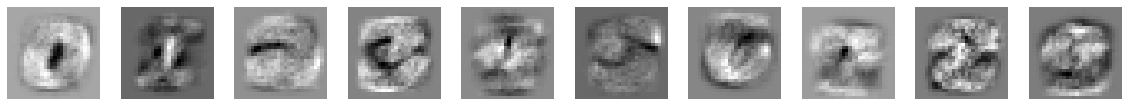

In [38]:
plt.figure(figsize=(20, 20))
num_classes = 10

for c in range(num_classes):
    f = plt.subplot(10, num_classes, 1 * num_classes + c + 1)
    f.axis('off')
    plt.imshow(np.reshape(W[:,c],[28,28]), cmap='gray')
plt.show()

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

_Image Classification - Softmax Regression_ <br/>
by _Benjamin Voigt, Klaus Strohmenger, Christian Herta_ <br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2020 _Benjamin Voigt, Klaus Strohmenger, Christian Herta_

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.